In [ ]:
import spikeinterface.full as si
from spikeinterface.preprocessing import correct_motion
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time, shutil
import spikeinterface.qualitymetrics as sqm

spikeglx_folder = 'NPX_JJ250713_i2_g3'
stream_names, stream_ids = si.get_neo_streams('spikeglx',spikeglx_folder)
print(stream_names)
raw_rec = si.read_spikeglx(spikeglx_folder, stream_name='imec0.ap', load_sync_channel=False)
raw_rec.get_probe().to_dataframe()
rec3 = si.highpass_filter(recording=raw_rec, freq_min=300.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec3)
rec3 = rec3.remove_channels(bad_channel_ids)
rec3 = si.phase_shift(rec3)
rec3 = si.common_reference(rec3, operator="median", reference="global")

c:\Users\admin\.conda\envs\fob_kilosort\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing with dredge_fast


Solve: 100%|██████████| 8/8 [00:00<00:00, 356.05it/s]


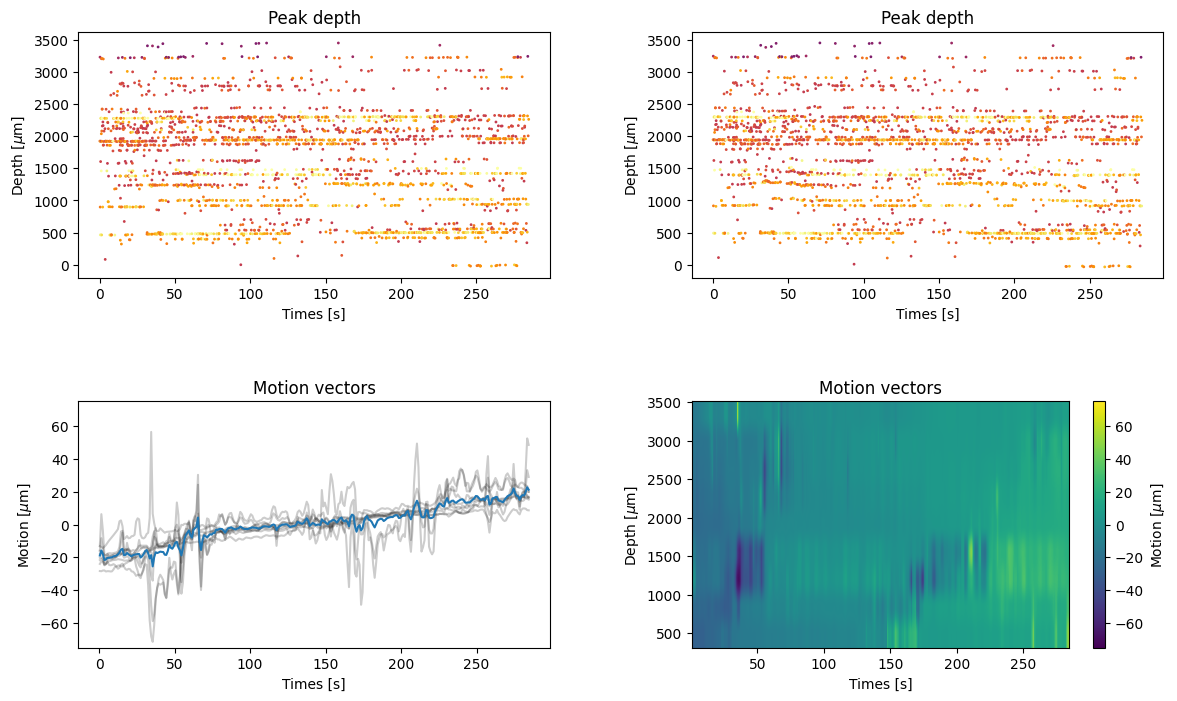

In [ ]:
job_kwargs = dict(n_jobs=16, chunk_duration="6s", progress_bar=True) # 4 is ok?
preset = 'dredge'
print("Computing with", preset)
folder = Path("./folder_KS4/motion") / preset
if folder.exists():
    shutil.rmtree(folder)
corrected_rec, motion_info = si.correct_motion(recording=rec3, preset=preset, folder=folder, output_motion_info=True, **job_kwargs)
motion_info = si.load_motion_info(folder)
fig = plt.figure(figsize=(14, 8))
si.plot_motion_info(motion_info, rec3,figure=fig,color_amplitude=True,amplitude_cmap="inferno",scatter_decimate=10,)

In [ ]:
job_kwargs = dict(n_jobs=18, chunk_duration='8s', progress_bar=True)
corrected_rec = corrected_rec.save(folder= './SI/preprocess', format='binary', **job_kwargs)
from spikeinterface.sorters import run_sorter
sorting_KS4 = run_sorter(sorter_name="kilosort4", recording=corrected_rec, folder="./SI/KS4", nblocks=0)

write_binary_recording 
n_jobs=16 - samples_per_chunk=119,999 - chunk_memory=175.32 MiB - total_memory=2.74 GiB - chunk_duration=4.00s


100%|██████████| 96/96 [00:21<00:00,  4.43it/s] 


In [ ]:
analyzer = si.create_sorting_analyzer(sorting_KS4, corrected_rec, sparse=True, format="memory")
job_kwargs = dict(n_jobs=16, chunk_duration="2s", progress_bar=True)
analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
analyzer.compute("waveforms",  ms_before=1.5,ms_after=2., **job_kwargs)
analyzer.compute("templates", operators=["average", "median", "std"],**job_kwargs)
analyzer.compute("noise_levels", **job_kwargs)
analyzer.compute("correlograms", **job_kwargs)
analyzer.compute("unit_locations", **job_kwargs)
analyzer.compute("spike_amplitudes", **job_kwargs)
analyzer.compute("template_similarity", **job_kwargs)

import spikeinterface.qualitymetrics as sqm
qm_params = sqm.get_default_qm_params()
qm_params["isi_violation"]["min_isi_ms"] = 0.1
qm_params["presence_ratio"]["bin_duration_s"] = 10

analyzer.compute('quality_metrics',qm_params, **job_kwargs)

analyzer_saved = analyzer.save_as(folder= "./SI/analyzer", format="binary_folder")
si.export_report(analyzer_saved, './SI/report', format='png')

c:\Users\admin\.conda\envs\fob_kilosort\lib\site-packages\spikeinterface\core\job_tools.py:103: UserWarning: `n_jobs` is not set so parallel processing is disabled! To speed up computations, it is recommended to set n_jobs either globally (with the `spikeinterface.set_global_job_kwargs()` function) or locally (with the `n_jobs` argument). Use `spikeinterface.set_global_job_kwargs?` for more information about job_kwargs.
  warnings.warn(
spike_amplitudes: 100%|██████████| 143/143 [00:04<00:00, 30.28it/s]
c:\Users\admin\.conda\envs\fob_kilosort\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:908: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
c:\Users\admin\.conda\envs\fob_kilosort\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\admin\.conda\env

In [ ]:
# import os
# os.remove('./SI/preprocess/traces_cached_seg0.raw')

PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: './SI/preprocess/traces_cached_seg0.raw'